### Get necessary modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### Read the train images in an array

In [4]:
# Define the folders containing the data
train_back = 'train_back'
train_stomach = 'train_stomach'
test_back = 'test_back'
test_stomach= 'test_stomach'

831


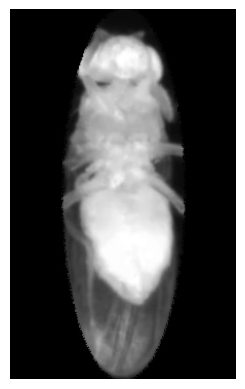

In [5]:
#read the images of down facing flies into the array images
images = []
for filename in os.listdir(train_stomach):
    img = cv2.imread(os.path.join(train_stomach, filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

plt.imshow(images[2],cmap='gray')
plt.axis('off')
print(len(images))

In [6]:
#read the images of up facing flies into the array images
for filename in os.listdir(train_back):
    img = cv2.imread(os.path.join(train_back, filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)
print(len(images)-831)

740


(-0.5, 219.5, 359.5, -0.5)

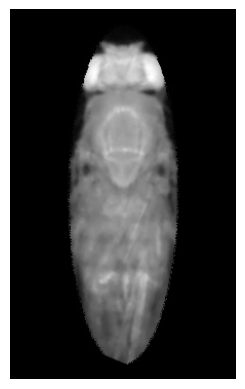

In [7]:
plt.imshow(images[1001],cmap='gray')
plt.axis('off')

In [8]:
# Create the labels array
labels1 = np.full(831,1) #make sure to input the correct length for each image type
labels2 = np.full(740,2)
labels = np.concatenate((labels1,labels2)) 
print(len(labels))

1571


### Convert the images with histogram equalization and normalise the flattened array

In [9]:
histogramImages = []
for i in range(len(images)):
    histogramImage = cv2.equalizeHist(images[i])
    histogramImages.append(histogramImage)

In [10]:
images_data = np.array(histogramImages)

In [11]:
print(images_data.shape)
nb_samples, height, width = images_data.shape

(1571, 360, 220)


(1571, 79200)


(-0.5, 219.5, 359.5, -0.5)

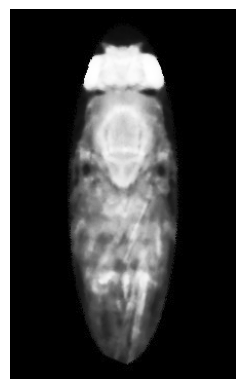

In [12]:
#we reshape the image data to a flattened array and normalise the images
images_flat = images_data.reshape(nb_samples, height*width)
print(images_flat.shape)

normalized_images = (images_flat - images_flat.mean(axis=1, keepdims=True)) / images_flat.std(axis=1, keepdims=True)

image_unflat = normalized_images.reshape((1571,height,width))
plt.imshow(image_unflat[1001],cmap='gray')
plt.axis('off')

### Perform PCA for dimensionality reduction and feature extraction

In [13]:
pca_test = PCA(n_components=5)
converted_data = pca_test.fit_transform(normalized_images)
# Get the number of principal components
num_components = converted_data.shape[1]
print(converted_data.shape)

(1571, 5)


Text(0, 0.5, 'Principal Component 4')

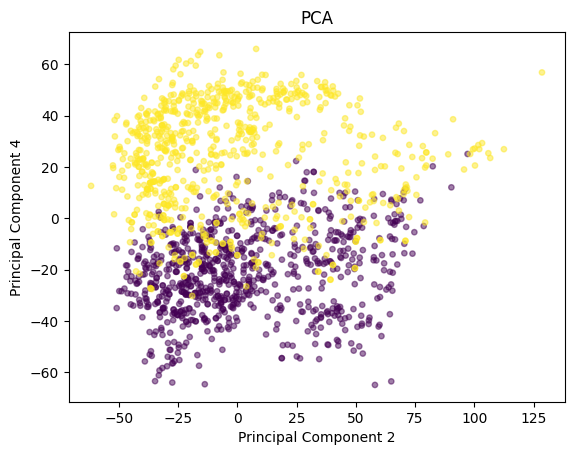

In [14]:
#plot the resulting dataset projected onto the first 2 eigenvectors
plt.scatter(converted_data[:,1], converted_data[:,2], s = 15, c = labels, cmap='viridis', alpha=0.5)
plt.title('PCA')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 4')

### Apply PCA to training dataset and create SVM classifier

In [15]:
# Get the number of samples
number = len(normalized_images)

# Generate random permutation of indices
indices = np.random.permutation(number)

# Shuffle both arrays based on the same permutation
X_train = normalized_images[indices]
Y_train = labels[indices]

# Project the data onto the selected eigenvectors
pca = PCA(n_components=5).fit(X_train)
X_train_pca = pca.transform(X_train)

#build SVM classifier
svmClassifier = SVC(kernel = 'rbf', class_weight='balanced')
svmClassifier.fit(X_train_pca, Y_train)

SVC(class_weight='balanced')

### Get the test data

In [16]:
# Read test images
images_test = []
for filename in os.listdir(test_stomach):
    img = cv2.imread(os.path.join(test_stomach, filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_hist = cv2.equalizeHist(img)
        images_test.append(img_hist)
nb_stomachTest = len(images_test)
labels1_test = np.full(nb_stomachTest,1)

for filename in os.listdir(test_back):
    img = cv2.imread(os.path.join(test_back, filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_hist = cv2.equalizeHist(img)
        images_test.append(img_hist)
labels2_test = np.full(len(images_test)-nb_stomachTest,2)

labels_test = np.concatenate((labels1_test,labels2_test))
images_data_test = np.array(images_test)
nb_samples, height, width = images_data_test.shape
images_flat_test = images_data_test.reshape(nb_samples, height*width)

normalized_images_test = (images_flat_test - images_flat_test.mean(axis=1, keepdims=True)) / images_flat_test.std(axis=1, keepdims=True)

# Generate random permutation of indices
indices_test = np.random.permutation(nb_samples)

# Shuffle both arrays based on the same permutation
X_test = normalized_images_test[indices_test]
Y_test = labels_test[indices_test]


### Predict on the test data to determine accuracy

In [17]:
# Perform PCA on test set
X_test_pca = pca.transform(X_test)

#Predict on test set
pred_y = svmClassifier.predict(X_test_pca)

#Get accuracy of prediction
accuracy = accuracy_score(Y_test, pred_y)
print(accuracy)

0.989010989010989


Confusion Matrix:
[[197   4]
 [  1 253]]


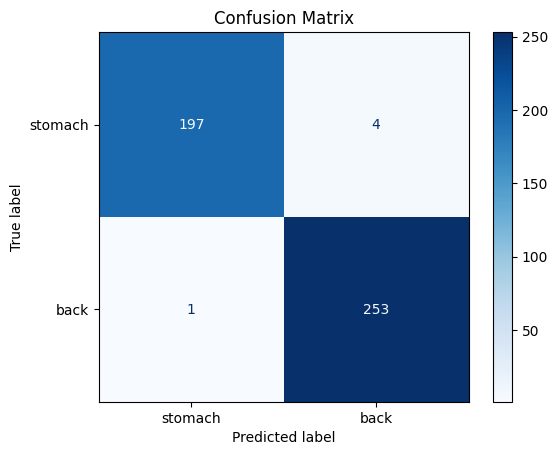

In [18]:
# Plot the confusion matrix

y_pred = pred_y - 1
y_test = Y_test - 1
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
class_names = ['stomach', 'back']

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#save pca model
filename1 = 'pca_model_added.sav'
joblib.dump(pca, filename1)

In [ ]:
#save classifier
filename = 'finalized_model_added.sav'
joblib.dump(svmClassifier, filename)